# 05: PINNs and steady-state heat transfer

**Exercise:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/05-pinn-heat-transfer/05-pinn-heat-transfer-exercise.ipynb)
**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/05-pinn-heat-transfer/05-pinn-heat-transfer.ipynb)

# Solving the Steady-State Heat Transfer Problem Using PINNs

The steady-state heat transfer problem is governed by the Laplace's equation in the absence of internal heat sources:

$$
\nabla^2 T(x,y) = 0
$$

Where $ T(x,y) $ represents the temperature distribution over a 2D domain.

## Approach:

1. **Neural Network Architecture**:
   - Utilize a feed-forward neural network with multiple layers and neurons.
   - The network will take spatial coordinates $(x,y)$ as input and produce the predicted temperature $ T(x,y) $ at that point.

2. **Physics-Informed Loss**:
   - The loss function will be a combination of:
     1. A term ensuring the boundary conditions for the predicted temperature.
     2. A term ensuring the Laplace's equation (PDE) is satisfied across the domain.
   
   - This is achieved by utilizing colocation points within the domain and on the boundaries. At each point, the PDE's residual (difference between its left and right sides) is evaluated using the neural network's prediction and gradients.

3. **Training**:
   - The objective is to minimize the combined loss, ensuring the PDE and boundary conditions are met.
   - Backpropagation will be employed to update the weights of the network, with optimization algorithms like Adam or L-BFGS.

4. **Prediction**:
   - After training, the network can estimate the temperature distribution $ T(x,y) $ for any point within the domain. This prediction respects the Laplace's equation and boundary conditions.

Using PINNs eliminates the need for a traditional meshing process present in methods like Finite Element or Finite Difference. It seamlessly incorporates the physics during training, enabling accurate predictions even with limited data availability.

![Heat transfer](../04-pde-fdm/2d-heat-transfer.png)

## Colocation Points

In physics-informed neural networks (PINNs), we approximate the solution to a partial differential equation (PDE) using a neural network. Unlike traditional deep learning problems where the network is trained solely on data points (e.g., labeled images in image classification), PINNs leverage the known physics (expressed as differential equations) of the problem. The goal is to find a neural network solution that both fits the provided data and also satisfies the PDE across the entire domain.

### Importance of Colocation Points:

1. **Enforce PDE Constraints**: 
   - Colocation points are used to ensure that the PDE constraints are satisfied not just at the observed data points, but across the entire domain of interest. 
   - These points allow us to enforce the differential equation by evaluating the residuals (i.e., the difference between the left and right side of the PDE) at these points and minimizing them during training.

2. **Boundary Conditions**: 
   - For problems like heat transfer, boundary conditions (specified values or gradients on the boundaries) are crucial. 
   - By placing colocation points on the boundaries, we can ensure the neural network respects these boundary conditions.

3. **Improved Generalization**: 
   - By ensuring that the neural network solution adheres to the underlying physics across the domain, PINNs often exhibit better generalization capabilities. 
   - For instance, even if you have sparse data in some regions, the model can still provide accurate predictions because it's being guided by the PDE.

4. **Regularization**: 
   - The physics (PDE) provides an inherent regularization to the problem. 
   - By enforcing the PDE at colocation points, the neural network is less likely to overfit to noisy data since it also has to satisfy the PDE.

5. **Domain and Boundary Sampling**: 
   - As observed in the provided code, the `DataGeneratorXY` class generates random colocation points within the domain (`x_dom`, `y_dom`) and on the boundaries (`x_bc_left`, `x_bc_right`, `x_bc_bot`, `x_bc_top`). 
   - This distributed sampling helps in adequately enforcing both the PDE and the boundary conditions across the computational domain.

6. **Visualization and Debugging**: 
   - By plotting the colocation points, as done in the `plot_data` method, we can visually inspect the distribution of points to ensure that there's adequate coverage across the domain and boundaries. 
   - It's a useful check to make sure the physics will be well-enforced during training.

In summary, colocation points in PINNs are a critical component that allows the integration of physical knowledge (PDEs and boundary conditions) into the neural network training process, enabling accurate predictions even with limited or noisy data.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import cycle
cycol = cycle('bgrcmk')

class DataGeneratorXY:
    """ Generates 2D collocation grid for a rectangular domain
    """
    def __init__(self,
                 X=[0., 1.],
                 Y=[0., 1.],
                 targets=['domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
                 num_sample=10000):
        'Initialization'
        self.Xdomain = X
        self.Ydomain = Y
        self.targets = targets
        self.num_sample = num_sample
        self.input_data = None
        self.target_data = None
        self.set_data()

    def __len__(self):
        return self.input_data[0].shape[0]

    def set_data(self):
        self.input_data, self.target_data = self.generate_data()

    def get_data(self):
        return self.input_data, self.target_data

    def generate_data(self):
        num_sample = int(self.num_sample/2)
        counter = 0

        # domain points
        x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
        y_dom = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
        ids_dom = np.arange(x_dom.shape[0])
        counter += ids_dom.size

        # bc points
        num_sample_per_edge = int(num_sample/4)

        # left bc points
        x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
        y_bc_left = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
        ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
        counter += ids_bc_left.size

        # right bc points
        x_bc_right = np.full(num_sample_per_edge, self.Xdomain[1])
        y_bc_right = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
        ids_bc_right = np.arange(x_bc_right.shape[0]) + counter
        counter += ids_bc_right.size

        # bot bc points
        x_bc_bot = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample_per_edge)
        y_bc_bot = np.full(num_sample_per_edge, self.Ydomain[0])
        ids_bc_bot = np.arange(x_bc_bot.shape[0]) + counter
        counter += ids_bc_bot.size

        # top bc points
        x_bc_top = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample-num_sample_per_edge)
        y_bc_top = np.full(num_sample-num_sample_per_edge, self.Ydomain[1])
        ids_bc_top = np.arange(x_bc_top.shape[0]) + counter
        counter += ids_bc_top.size

        ids_bc = np.concatenate([ids_bc_left, ids_bc_right, ids_bc_bot, ids_bc_top])
        ids_all = np.concatenate([ids_dom, ids_bc])

        ids = {
            'domain': ids_dom,
            'bc-left': ids_bc_left,
            'bc-right': ids_bc_right,
            'bc-bot': ids_bc_bot,
            'bc-top': ids_bc_top,
            'bc': ids_bc,
            'all': ids_all
        }

        assert all([t in ids.keys() for t in self.targets]), \
          'accepted target types: {}'.format(ids.keys())

        input_data = [
            torch.tensor(np.concatenate([x_dom, x_bc_left, x_bc_right, x_bc_bot, x_bc_top]).reshape(-1,1), dtype=torch.float32, requires_grad=True),
            torch.tensor(np.concatenate([y_dom, y_bc_left, y_bc_right, y_bc_bot, y_bc_top]).reshape(-1,1), dtype=torch.float32, requires_grad=True),
        ]

        total_sample = input_data[0].shape[0]

        target_data = []
        for i, tp in enumerate(self.targets):
            zeros_tensor = torch.zeros(len(ids[tp]), 1, dtype=torch.float32)
            target_data.append(
                (ids[tp], zeros_tensor)
            )

        return input_data, target_data
    
    def plot_data(self):
        fig = plt.figure()
        for t, (t_idx, t_val) in zip(self.targets, self.target_data):
            x_data = self.input_data[0][t_idx,:].detach().numpy()
            y_data = self.input_data[1][t_idx,:].detach().numpy()
            plt.scatter(x_data, y_data, label=t, c=next(cycol))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
        fig.tight_layout()
        plt.show()


> Vary the number of colocation points:

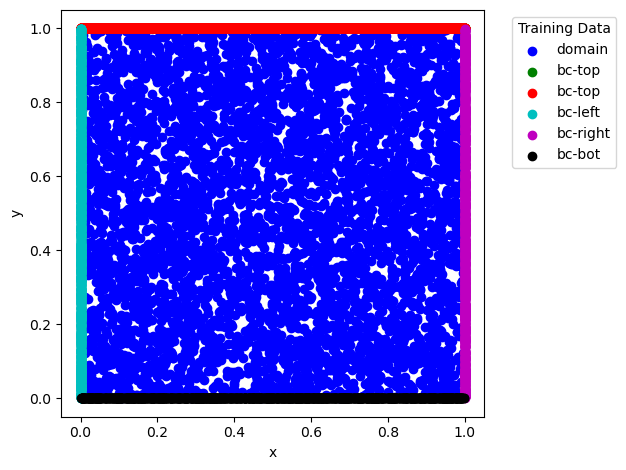

In [3]:
dg = DataGeneratorXY([0.,1.], [0.,1.], num_sample=10000,
                     targets=['domain', 'bc-top', 'bc-top', 'bc-left', 'bc-right', 'bc-bot'])
input_data, target_data = dg.get_data()
dg.plot_data()

## PINNs Steady State Heat Transfer

/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_11825/3982283903.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True)
/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_11825/3982283903.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32, requires_grad=True)


Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000, Loss: 0.879266083240509
Epoch 100/1000, Loss: 0.3673993945121765
Epoch 200/1000, Loss: 0.2561258375644684
Epoch 300/1000, Loss: 0.1404949575662613
Epoch 400/1000, Loss: 0.12836021184921265
Epoch 500/1000, Loss: 0.12063668668270111
Epoch 600/1000, Loss: 0.1147485002875328
Epoch 700/1000, Loss: 0.11118556559085846
Epoch 800/1000, Loss: 0.1076766774058342
Epoch 900/1000, Loss: 0.10539714246988297


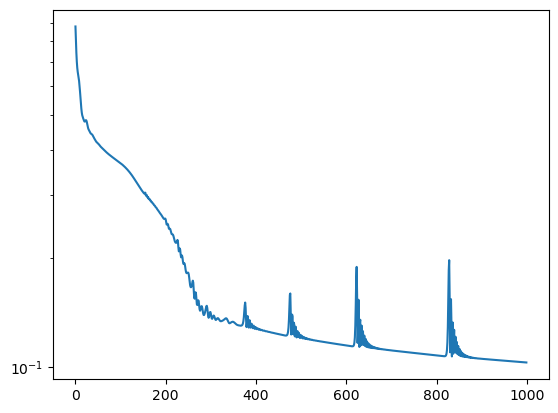

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# Define the neural network model
class HeatNet(nn.Module):
    def __init__(self):
        super(HeatNet, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )

    def forward(self, x, y):
        x = x.view(-1, 1)
        y = y.view(-1, 1)
        xy = torch.cat([x, y], dim=1)
        T = self.hidden_layers(xy)
        return T

    def loss_function(self, x, y):
        T = self.forward(x, y)
        T_x = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
        T_y = torch.autograd.grad(T.sum(), y, create_graph=True)[0]
        T_xx = torch.autograd.grad(T_x.sum(), x, create_graph=True)[0]
        T_yy = torch.autograd.grad(T_y.sum(), y, create_graph=True)[0]
        # PDE loss
        loss_PDE = ((T_xx + T_yy)**2).mean()

        # BC loss
        mask_left = (x == 0)
        mask_right = (x == 1)
        mask_bottom = (y == 0)
        mask_top = (y == 1) 

        loss_left = (T[mask_left]**2).mean()
        loss_right = (T[mask_right]**2).mean()
        loss_bottom = (T[mask_bottom]**2).mean()
        loss_top = ((T[mask_top] - 1)**2).mean()

        loss = loss_PDE + loss_left + loss_right + loss_bottom + loss_top
        return loss

# Instantiate the model
model = HeatNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the training data
dg = DataGeneratorXY([0.,1.], [0.,1.], num_sample=10000,
                     targets=['domain', 'bc-top', 'bc-top', 'bc-left', 'bc-right', 'bc-bot'])
input_data, target_data = dg.get_data()
x_data, y_data = input_data

# Convert numpy arrays to PyTorch tensors
x_data = torch.tensor(x_data, dtype=torch.float32, requires_grad=True)
y_data = torch.tensor(y_data, dtype=torch.float32, requires_grad=True)

# Training loop
losses = []
epochs = 1000
for epoch in tqdm(range(epochs), desc='Training progress'):
    optimizer.zero_grad()
    loss = model.loss_function(x_data, y_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')


# Plot the loss
plt.figure()
plt.semilogy(losses)
plt.show()


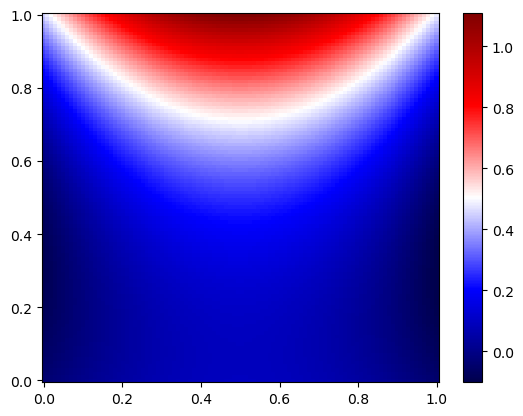

In [7]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

# Flatten and stack tensors
# Flatten tensors
x_test_flat = torch.tensor(x_test.flatten(), dtype=torch.float32, requires_grad=True)
y_test_flat = torch.tensor(y_test.flatten(), dtype=torch.float32, requires_grad=True)

# Pass through the model
T_test_flat = model(x_test_flat, y_test_flat)
T_test = T_test_flat.detach().numpy().reshape(100, 100)

plt.pcolor(x_test, y_test, T_test, cmap='seismic', shading='auto')
plt.colorbar()
plt.show()

### DeepXDE implementation

In [15]:
!pip3 install deepxde --quiet
!pip3 install tensorflow --quiet

In [16]:
!DDE_BACKEND=tensorflow

### Glorot initialization


The **Glorot uniform initializer**, also known as **Xavier uniform initializer**, is a method used to set the initial random weights of neural networks in a way that helps in achieving faster and more effective training. The Glorot uniform initializer sets the weights by drawing them from a distribution that is uniform within a specific range.

The range for drawing the weights $ w $ is:

$$ -\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}} \leq w \leq \sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}} $$

Where:
- $ n_{\text{in}} $ is the number of input units in the layer (i.e., the size of the previous layer).
- $ n_{\text{out}} $ is the number of output units in the layer (i.e., the size of the current layer).

The name "Glorot" comes from the first author of a 2010 paper that introduced this initializer, Xavier Glorot.

The Glorot uniform initializer is particularly designed for Sigmoid and hyperbolic tangent (tanh) activation functions. If you're using ReLU activations or its variants, the He initializer might be more appropriate.

In popular deep learning frameworks like TensorFlow and Keras, the Glorot uniform initializer is often the default weight initializer.

In [17]:
import numpy as np
import tensorflow.compat.v2 as tf
import deepxde as dde

def pde(x, T):
    dT_xx = dde.grad.hessian(T, x, i=0, j=0)
    dT_yy = dde.grad.hessian(T, x, i=1, j=1)
    return dT_xx + dT_yy

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_t(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)


# Geometry and time domain
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Boundary conditions
bc_l = dde.DirichletBC(geom, lambda x: 0, boundary_l)
bc_r = dde.DirichletBC(geom, lambda x: 0, boundary_r)
bc_b = dde.DirichletBC(geom, lambda x: 0, boundary_b)
bc_t = dde.DirichletBC(geom, lambda x: 1, boundary_t)

# Define the data
data = dde.data.PDE(
    geom,
    pde,
    [bc_l, bc_r, bc_b, bc_t],
    num_domain=10000,
    num_boundary=2000
)

# Define the neural network
net = dde.nn.FNN([2] + [40] * 4 + [1], "tanh", "Glorot uniform")

# Define the model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=1000)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.024796 s



/opt/homebrew/Caskroom/miniforge/base/envs/gns/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.231423 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.42e-03, 2.00e-02, 7.41e-03, 1.13e-02, 1.32e+00]    [3.42e-03, 2.00e-02, 7.41e-03, 1.13e-02, 1.32e+00]    []  


2023-09-24 11:20:47.829592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


1000      [4.18e-03, 2.43e-02, 2.95e-02, 2.26e-03, 4.38e-02]    [4.18e-03, 2.43e-02, 2.95e-02, 2.26e-03, 4.38e-02]    []  

Best model at step 1000:
  train loss: 1.04e-01
  test loss: 1.04e-01
  test metric: []

'train' took 42.316274 s



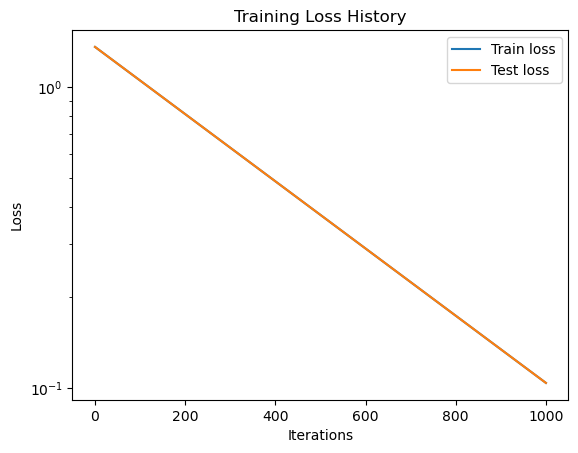

In [18]:
# Plot loss history
dde.utils.external.plot_loss_history(losshistory)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss History")
# Set y-axis to log scale
plt.yscale('log')
plt.show()

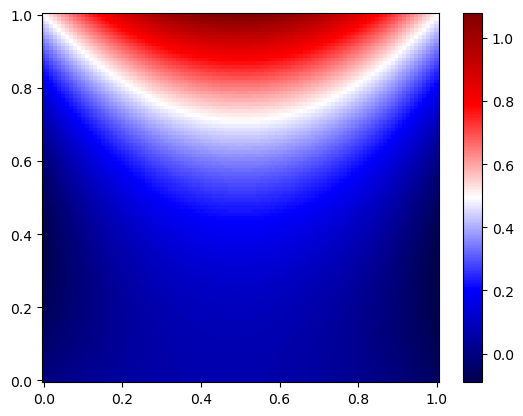

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a grid over the domain
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Stack and reshape for prediction
XY = np.vstack((X.ravel(), Y.ravel())).T

# Predict using the model
T = model.predict(XY)
T = T.reshape(X.shape)

# Plot
plt.pcolor(X, Y, T, cmap='seismic', shading='auto')
plt.colorbar()
plt.show()